## Constrained docking protocol

In this tutorial, we will demonstrate how you can use `rush-py` to conduct a large-scale virtual screen on a target using a constrained docking protocol.

We will use the Zinc20 database of FDA approved drugs as our sample ligand database, but Rush's capability means that this protocol could scale to screen tens of millions of ligands.

## 0.0) Imports

In [1]:
import rdkit
import os 
import os
import math
import numpy as np
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolFromSmarts, SDMolSupplier
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS, rdRascalMCES
from rdkit.Chem import rdDistGeom
from rdkit import Chem
from rdkit.Chem.rdMolAlign import AlignMol
from rdkit.Chem import rdForceFieldHelpers

from typing import List, Optional

In [2]:
# CODE

def get_mcs(query_ligand: Chem.Mol, reference: Chem.Mol, timeout=3600, **kwargs) -> Optional[Chem.Mol]:
    if kwargs.get("ignore_heavy_atom"):
        atom_comparision_method = rdFMCS.AtomCompare.CompareAnyHeavyAtom
    else:
        atom_comparision_method = rdFMCS.AtomCompare.CompareAnyHeavyAtom

    if kwargs.get("ignore_bond_order"):
        bond_comparision_method = rdFMCS.BondCompare.CompareAny
    else:
        bond_comparision_method = rdFMCS.BondCompare.CompareOrder

    if kwargs.get("use_rascal_mces"):
        mcs = rdRascalMCES.FindMCES(
                [reference, query_ligand],
                atomCompare=atom_comparision_method,
                bondCompare=bond_comparision_method
            )

    else:
        mcs = rdFMCS.FindMCS(
            [reference, query_ligand],
            threshold=0.9,
            completeRingsOnly=kwargs.get("complete_rings_only", False),
            atomCompare=atom_comparision_method,
            bondCompare=bond_comparision_method,
            timeout=timeout
            )
    if mcs_result_exists(mcs):
        return Chem.MolFromSmarts(mcs.smartsString, mergeHs=True)


def meets_similarity_threshold(mcs, reference, min_threshold=0.2):
    if mcs_result_exists(mcs):
        mcs_mol = Chem.MolFromSmarts(mcs.smartsString, mergeHs=True)
        match_ratio = mcs_mol.GetNumAtoms() / reference.GetNumAtoms()

        return match_ratio >= min_threshold
    
    return False


def get_filtered_mcs(mcss, reference):
    return [mcs for mcs in mcss if meets_similarity_threshold(mcs, reference)]


def get_mcs_molecule(mcs) -> Optional[Chem.Mol]:
    if mcs_result_exists(mcs):
        return  Chem.MolFromSmarts(mcs.smartsString, mergeHs=True)
    return None


INITIAL_FILTER_DISTANCE = 1000
def get_diverse_substructure_matches(reference, mcs_mol, minimum_difference=5) -> List[Chem.Mol]:
    """
    Prunes a list of MCS substructure hits within a molecule and keeps only those which are at least the minimum difference apart
    This is to capture as many unique substructure hits across the query and the ligand, but discard those that are not meaningfully different (e.g. a rotation of the bond) 
    A default of 5 is an effective balance between retaining novel hits and discarding excessively similar values.
    """
    substructures = reference.GetSubstructMatches(mcs_mol, uniquify=False)

    output_structures = [
        substructures[0]
    ]
    for substructure in substructures[1:]:
        distance = INITIAL_FILTER_DISTANCE
        j = 0

        while (distance >= minimum_difference) and j < len(output_structures):
            ref = np.array(output_structures[j])
            distance = sum(np.array(substructure) != ref)
            j += 1

        if distance >= minimum_difference:
            output_structures.append(substructure)
    
    return output_structures


def get_tethered_atoms(substruct_match) -> str:
    """
    Return a formatted string of atom indexes to pass to "TETHERED ATOMS" configuration option for rxdock

    Example input:
    (0, 1, 2)

    Example output:
    1,2,3
    """
    return ','.join(str(index + 1) for index in substruct_match)

def mcs_result_exists(mcs) -> bool:
    return mcs.smartsString and len(mcs.smartsString) > 0


def get_force_field(geom_calc, query_mol):
    ff = rdForceFieldHelpers.UFFGetMoleculeForceField(query_mol, confId=0)

    for i in geom_calc.coordMap:
        point = geom_calc.coordMap[i]
        point_idx = ff.AddExtraPoint(point.x, point.y, point.z, fixed=True) - 1
        ff.AddDistanceConstraint(point_idx, i, 0, 0, 100.0)
    ff.Initialize()

    return ff


def get_template_aligned_pose(query, reference, query_ligand_map, geom_calc, n_tries=5) -> Chem.Mol:
    """
    Align query molecule to "template" (reference molecule)
    Distance constrints are enforced on the input ligand to mould the geometry of its matching substructure to that in the template
    """
    temp_query_mol = Chem.Mol(query) 

    min_energy = np.inf
    bestmol = None

    ff = get_force_field(geom_calc, temp_query_mol)
    AllChem.EmbedMolecule(temp_query_mol, geom_calc)
    # Need to error here if ci > 0

    for _ in range(n_tries):
        # We run the minimize numerous times from the beginning as `minimize` is stochastic in nature.
        # This behavior is not documented in RDKit.

        ff = get_force_field(geom_calc, temp_query_mol)
        AllChem.EmbedMolecule(temp_query_mol, geom_calc)

        minimize_tries = 20
        more_to_minimize = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
        while more_to_minimize and minimize_tries:
            more_to_minimize = ff.Minimize(energyTol=1e-4, forceTol=1e-3)
            minimize_tries -= 1

        current_energy = ff.CalcEnergy()
        print(f'{_} {current_energy}')
        if current_energy < min_energy:
            bestmol = Chem.Mol(
                temp_query_mol
            )
            min_energy = current_energy
        temp_query_mol = Chem.Mol(
            query
        )
        AllChem.EmbedMolecule(temp_query_mol, geom_calc)

    AlignMol(bestmol, reference, atomMap=query_ligand_map)

    return bestmol


def get_substructure_matches(molecule, mcs_mol, uniquify=True) -> Chem.Mol:
    return molecule.GetSubstructMatches(mcs_mol, uniquify=uniquify)        


def get_dist_geom_calculator(reference, query_matches, reference_match, constrained_atoms):
    geom_calc = rdDistGeom.ETKDGv3()
    geom_calc.trackFailures = True
    geom_calc.coordMap = {
        query_matches[atom_idx]: reference.GetConformer().GetAtomPosition(reference_match[atom_idx]) for atom_idx in range(len(constrained_atoms))
    }

    return geom_calc


def get_initial_poses(query, reference, mcs_mol, max_symmetry=1000) -> List[Chem.Mol]:
    """
    Use maximum common substructure between query and template ligand to generate initial docking poses
    of query ligand

    NB: this function assumes that a MCS between the query and the substructure exists 
    """
    reference_matches = get_diverse_substructure_matches(reference, mcs_mol)
    molecule_matches = get_substructure_matches(query, mcs_mol)

    constrained_atoms = molecule_matches[0]
    constrained_atom_ids = get_tethered_atoms(constrained_atoms)

    molhits = query.GetSubstructMatch(
            mcs_mol
        ) 

    poses = []
    
    n_iterations = min(len(reference_matches), max_symmetry)

    for i in range(n_iterations):
        geom_calc = get_dist_geom_calculator(reference, molhits, reference_matches[i], constrained_atoms)
        
        posed_mol = get_template_aligned_pose(
            query,
            reference,
            [(m_idx, r_idx) for m_idx, r_idx in zip(molhits, reference_matches[i])],
            geom_calc
        )
        posed_mol.SetProp("TETHERED ATOMS", constrained_atom_ids)
        poses.append(posed_mol)

    return poses


def constrained_virtual_screen(reference, query_molecules):
    pass

In [3]:
# TEST

# Load the query ligand from SDF file 

suppl = Chem.SDMolSupplier('3pxy_B_JWS_withH.sdf')
reference_mol = next((m for m in suppl if m is not None), None)


#reference_mol = Chem.AddHs(reference_mol)
query_mol = MolFromSmiles("Fc1ccc(N)cc1")
query_mol = Chem.AddHs(query_mol)
Chem.rdDistGeom.EmbedMolecule(query_mol,1, randomSeed=0xf00d) # For reproducibility. In principle it won't matter much because we're moving it to fit the template


0

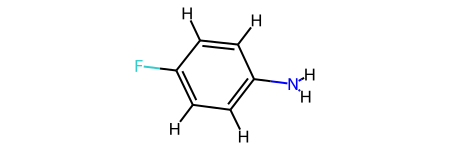

In [4]:
sdf_filename = 'query.sdf'

writer = Chem.SDWriter(sdf_filename)

if writer is not None:
    writer.write(query_mol)
    writer.close()


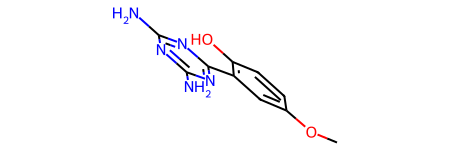

In [5]:
reference_mol

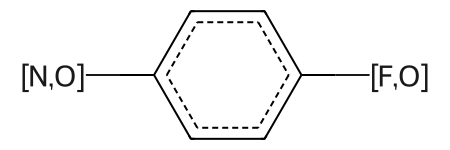

In [6]:
mcs_mol = get_mcs(query_mol, reference_mol)
mcs_mol

In [7]:
reference_mol.GetNumConformers()

1

0 6567372.739661868
1 6565823.915679738
2 6573735.933855311
3 6537000.8312216345
4 6565366.43165346
0 6574607.275716543
1 6532497.870886024
2 6572163.347846177
3 6532412.930794198
4 6570950.273172511
2


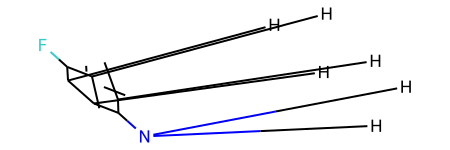

In [8]:
poses = get_initial_poses(query_mol, reference_mol, mcs_mol)
print(len(poses))
poses[0]

In [9]:
os.remove("pose.sdf")
sdf_filename = 'pose.sdf'

writer = Chem.SDWriter(sdf_filename)

if writer is not None:
    writer.write(poses[0])
    writer.close()
    print(f"Molecule saved to {sdf_filename}")
else:
    print("Failed to create SDWriter.")

Molecule saved to pose.sdf
